In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
DATA_DIR = '../data/internal'

In [3]:
class Config:
    device = 'cpu'
    epochs = 20
    seed = 0
    batch_size = 128
    embedding_dim = 32
    hidden_size = 16
    dropout_rate=0.4
    lr = 1e-3


config = Config()

In [4]:
def set_seed(seed_value=0):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


set_seed(config.seed)

In [5]:
train_data = pd.read_csv(os.path.join(DATA_DIR, 'data_train.csv'))
val_data = pd.read_csv(os.path.join(DATA_DIR, 'data_val.csv'))
user_data = pd.read_csv(os.path.join(DATA_DIR, 'user.csv'), index_col=0)
item_data = pd.read_csv(os.path.join(DATA_DIR, 'item.csv'), index_col=0)

In [6]:
original_user_ids = user_data.original_user_id-1
original_item_ids = item_data.original_item_id-1

In [7]:
user_data = user_data.drop(columns=['original_user_id'])
item_data = item_data.drop(columns=['original_item_id'])

In [8]:
n_user_features = user_data.shape[1]
n_item_features = item_data.shape[1]
n_user_features, n_item_features

(22, 19)

In [9]:
class MovieDataset(Dataset):
    def __init__(self, ratings, users, items):
        self.users = users
        self.items = items
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, ids):
        ratings = self.ratings.iloc[ids]

        user_ids = ratings.user_id.astype('int')
        item_ids = ratings.item_id.astype('int')

        users = self.users.iloc[user_ids]
        items = self.items.iloc[item_ids]

        return {
            "ratings": torch.tensor(ratings.rating, dtype=torch.long),
            "user_ids": torch.tensor(user_ids, dtype=torch.long),
            "item_ids": torch.tensor(item_ids, dtype=torch.long),
            "users_info": torch.tensor(users.to_numpy(), dtype=torch.float),
            "items_info": torch.tensor(items.to_numpy(), dtype=torch.float),
        }

In [10]:
train_dataset = MovieDataset(train_data, user_data, item_data)
val_dataset = MovieDataset(val_data, user_data, item_data)

In [11]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=False)

In [12]:
for data in train_dataloader:
    print(data['ratings'].shape)
    print(data['user_ids'].shape)
    print(data['item_ids'].shape)
    print(data['users_info'].shape)
    print(data['items_info'].shape)
    break

torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 22])
torch.Size([128, 19])


In [13]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim, hidden_size, dropout_rate):
        super().__init__()

        self.user_embed = nn.Embedding(n_users, embedding_dim=embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim=embedding_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim * 2 + n_item_features + n_user_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(hidden_size // 2, 1)

        # Weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, user_ids, item_ids, users_info, items_info):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)

        x = torch.cat([user_embeds, item_embeds, users_info, items_info], dim=1)

        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        
        return x

In [14]:
# class RecSysModel(nn.Module):
#     def __init__(self, n_users, n_items, embedding_dim, hidden_size):
#         super().__init__()

#         self.user_embed = nn.Embedding(n_users, embedding_dim=embedding_dim)
#         self.item_embed = nn.Embedding(n_items, embedding_dim=embedding_dim)

#         self.out = nn.Sequential(
#             nn.Linear(embedding_dim * 2 + n_item_features + n_user_features, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, 1),
#         )

#     def forward(self, user_ids, item_ids, users_info, items_info):
#         user_embeds = self.user_embed(user_ids)
#         item_embeds = self.item_embed(item_ids)

#         x = torch.cat([user_embeds, item_embeds, users_info, items_info], dim=1)

#         x = self.out(x)

#         return x

In [15]:
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over epochs.

    Parameters:
    - train_losses (list): List of training loss values for each epoch.
    - val_losses (list): List of validation loss values for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
def test_model(model: nn.Module, criterion, test_dataloader: DataLoader, device='cuda'):
    """
    Function that evaluates model on specified dataloader
    by specified loss function.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    criterion
      The loss function from pytorch
    test_dataloader: DataLoader
      The dataset for testing model

    Returns
    -------
    float: loss of model on given dataset
    """

    model.eval()
    model.to(device)

    # Test loss value
    test_loss = 0.0

    with torch.no_grad():
        for data in test_dataloader:
            
            user_ids = data['user_ids'].to(device)
            item_ids = data['item_ids'].to(device)
            users_info = data['users_info'].to(device)
            items_info = data['items_info'].to(device)
            ratings = data['ratings'].to(device)
            
            ratings = ratings.view(-1, 1).to(torch.float)            
            
            # Forward pass
            outputs = model(user_ids=user_ids, item_ids=item_ids, users_info=users_info, items_info=items_info)
            test_loss += criterion(outputs, ratings)

    # Computation of test loss
    test_loss /= len(test_dataloader)

    return test_loss.item()

In [17]:
def train_model(model: nn.Module, epochs: int, criterion, train_dataloader, validation_dataloader, load_ckpt: bool = False, load_ckpt_path: str or None = None, save_ckpt_path: str = 'best.pt', device: torch.device = 'cuda'):
    """
    Function that trains model using number of epochs, loss function, optimizer.
    Can use validation or test data set for evaluation.
    Calculates f1 score.

    Parameter
    ---------
    model : nn.Module
        Model to train.
    epochs: int
        Number of train epochs
    criterion
        The loss function from pytorch
    train_dataloader
        Dataloader of the train dataset
    train_dataloader
        Dataloader of the validation dataset
    load_ckpt: bool
        load model from checkpoint if true or train from scratch if false
    load_ckpt_path: str
        Path of already existing checkpoint to load model from
    save_ckpt_path: str
        Path of where to store the best model checkpoint
    device: torch.device
        PyTorch device
    """

    if load_ckpt_path is None:
        load_ckpt_path = save_ckpt_path

    model.train()
    model.to(device)

    # best score for checkpointing
    best = 1000000000.0
    train_losses = []
    val_losses = []

    first_epoch = 1

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)


    if (not load_ckpt):
        print('Training model from scratch!')
    else:
        isCkptExists = os.path.isfile(load_ckpt_path)        
        if (not isCkptExists):
            print('Checkpoint file does not exist. Training model from scratch!')
        else:
            checkpoint = torch.load(load_ckpt_path)
            best = checkpoint['best_score']
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            train_losses = checkpoint['train_losses']
            first_epoch = checkpoint['epoch'] + 1

    # Train the model
    for epoch in range(first_epoch, epochs + first_epoch):
        model.train()

        train_loss = 0.0

        bar = tqdm(train_dataloader)
        iterations = 0

        for data in bar:

            user_ids = data['user_ids'].to(device)
            item_ids = data['item_ids'].to(device)
            users_info = data['users_info'].to(device)
            items_info = data['items_info'].to(device)
            ratings = data['ratings'].to(device)
            
            ratings = ratings.view(-1, 1).to(torch.float)            
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(user_ids=user_ids, item_ids=item_ids, users_info=users_info, items_info=items_info)
            loss = criterion(outputs, ratings)

            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            iterations += 1
            bar.set_postfix(
                ({"loss": f"{train_loss/(iterations*train_dataloader.batch_size)}"}))

        # Computing loss
        train_loss /= len(train_dataloader.dataset)

        # Printing information in the end of train loop
        val_loss = test_model(model, criterion, validation_dataloader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        plot_losses(train_losses=train_losses, val_losses=val_losses)

        if val_loss < best:
            best = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_score': best,
            }, save_ckpt_path)

        print(f"Epoch {epoch}: \ntrain:\t\t(loss: {train_loss:.4f}) \nvalidation:\t(loss: {val_loss:.4f})\n")

In [18]:
model = RecSysModel(n_items=len(item_data), n_users=len(
    user_data), embedding_dim=config.embedding_dim, hidden_size=config.hidden_size, dropout_rate=config.dropout_rate).to(config.device)
# model = RecSysModel(n_items=len(item_data), n_users=len(
#     user_data), embedding_dim=config.embedding_dim, hidden_size=config.hidden_size).to(config.device)

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

Training model from scratch!


  0%|          | 0/522 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:44<00:00, 11.77it/s, loss=0.03667953124419711] 


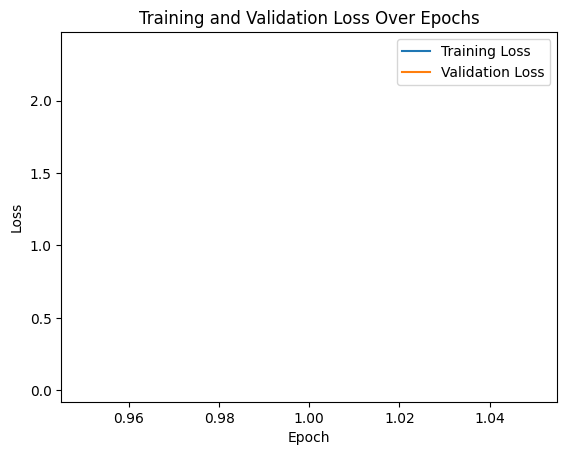

Epoch 1: 
train:		(loss: 0.0367) 
validation:	(loss: 2.3576)



100%|██████████| 522/522 [00:32<00:00, 16.24it/s, loss=0.02150940384458879] 


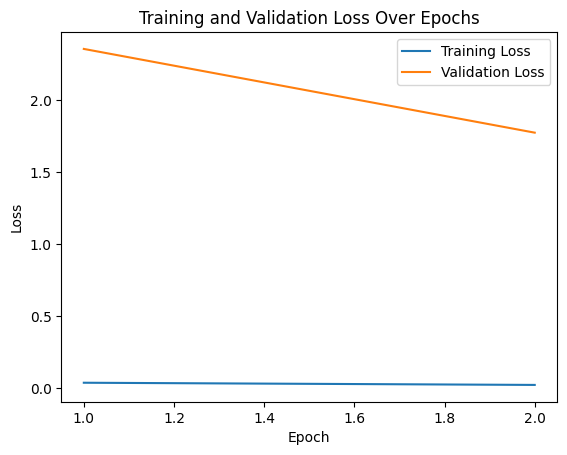

Epoch 2: 
train:		(loss: 0.0215) 
validation:	(loss: 1.7753)



100%|██████████| 522/522 [00:31<00:00, 16.31it/s, loss=0.017660584122342168]


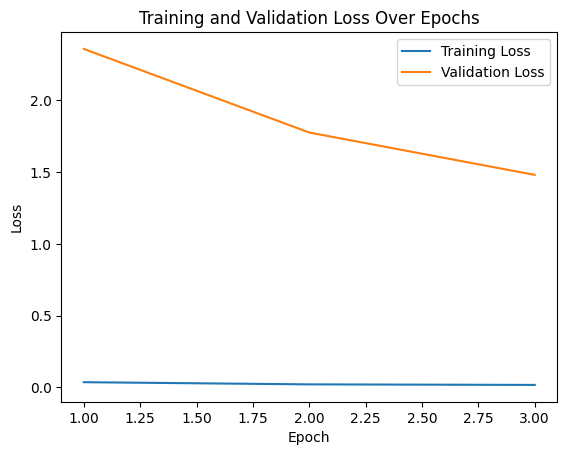

Epoch 3: 
train:		(loss: 0.0177) 
validation:	(loss: 1.4804)



100%|██████████| 522/522 [00:32<00:00, 16.27it/s, loss=0.015033366913297054]


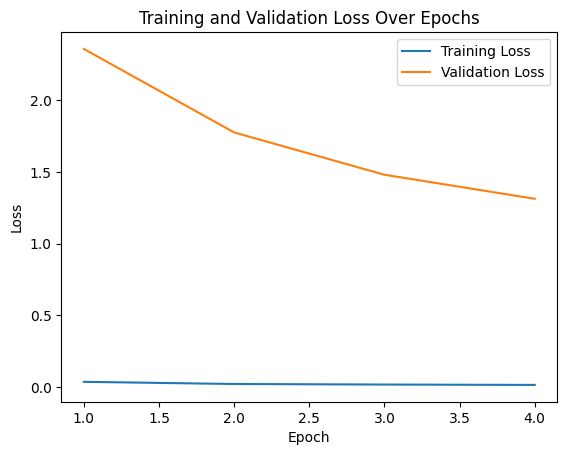

Epoch 4: 
train:		(loss: 0.0150) 
validation:	(loss: 1.3129)



100%|██████████| 522/522 [00:31<00:00, 16.41it/s, loss=0.013352179828446031]


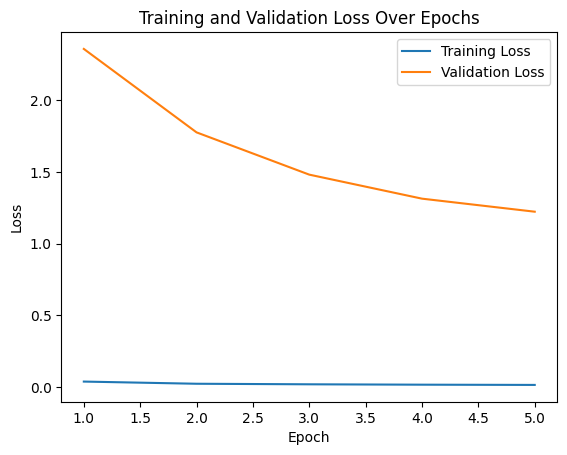

Epoch 5: 
train:		(loss: 0.0134) 
validation:	(loss: 1.2219)



100%|██████████| 522/522 [00:36<00:00, 14.49it/s, loss=0.012028065426239451]


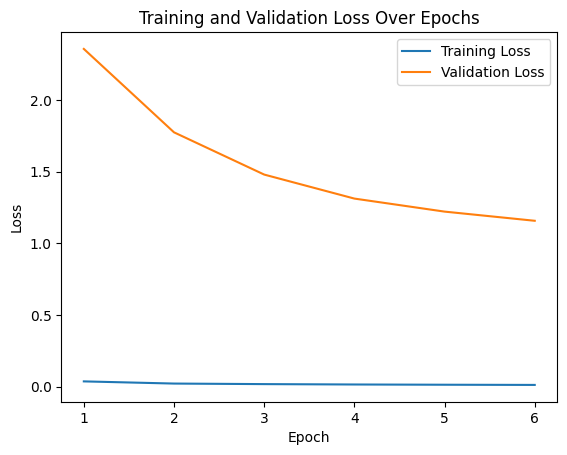

Epoch 6: 
train:		(loss: 0.0120) 
validation:	(loss: 1.1579)



100%|██████████| 522/522 [00:33<00:00, 15.65it/s, loss=0.011057257554154857]


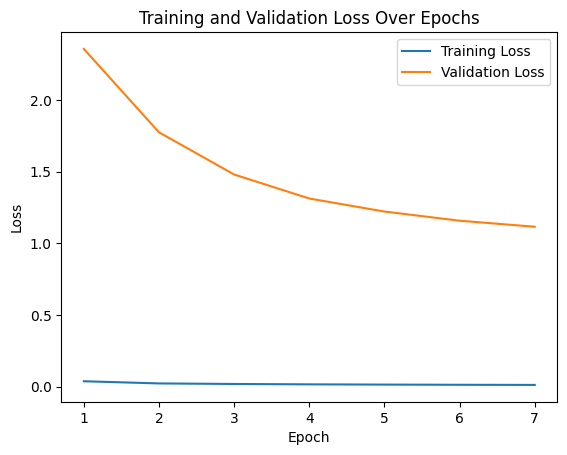

Epoch 7: 
train:		(loss: 0.0111) 
validation:	(loss: 1.1157)



100%|██████████| 522/522 [00:33<00:00, 15.67it/s, loss=0.010245514958668715]


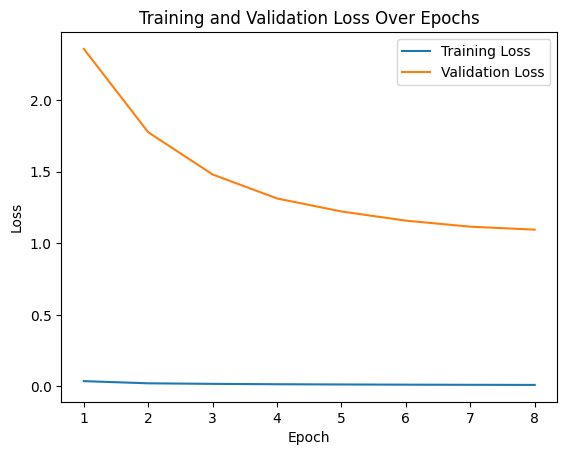

Epoch 8: 
train:		(loss: 0.0103) 
validation:	(loss: 1.0950)



100%|██████████| 522/522 [00:33<00:00, 15.74it/s, loss=0.009609424552819566]


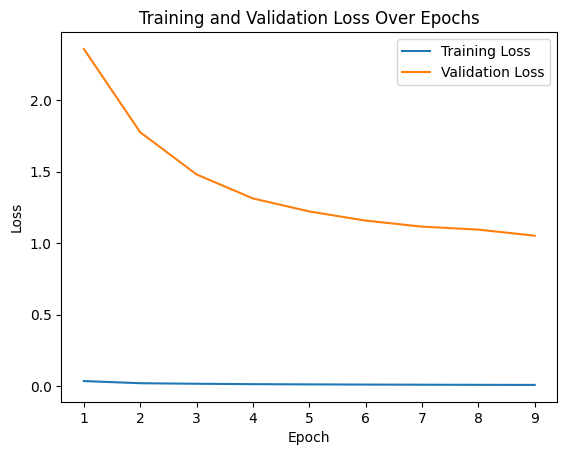

Epoch 9: 
train:		(loss: 0.0096) 
validation:	(loss: 1.0524)



100%|██████████| 522/522 [00:32<00:00, 16.02it/s, loss=0.008962308557996691]


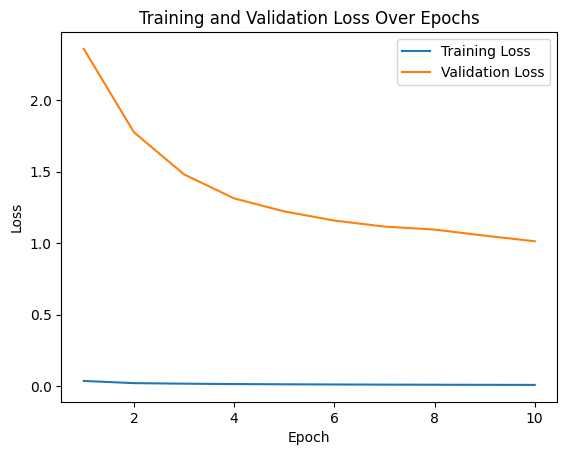

Epoch 10: 
train:		(loss: 0.0090) 
validation:	(loss: 1.0133)



100%|██████████| 522/522 [00:33<00:00, 15.69it/s, loss=0.008561101742088795]


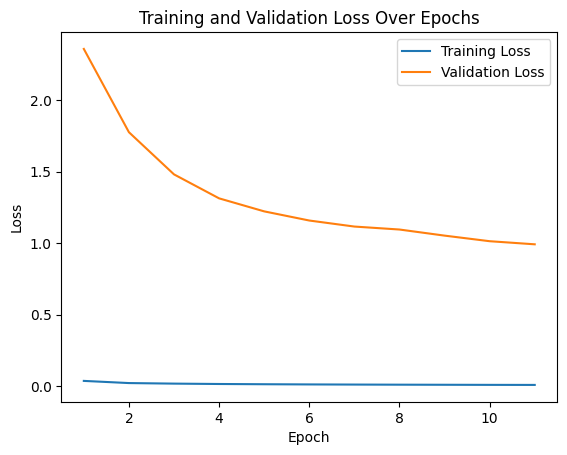

Epoch 11: 
train:		(loss: 0.0086) 
validation:	(loss: 0.9916)



100%|██████████| 522/522 [00:32<00:00, 15.84it/s, loss=0.008175259264243118]


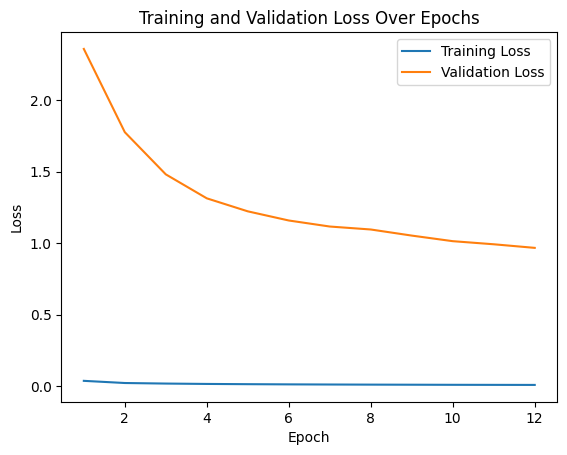

Epoch 12: 
train:		(loss: 0.0082) 
validation:	(loss: 0.9665)



100%|██████████| 522/522 [00:33<00:00, 15.61it/s, loss=0.00797205924063607] 


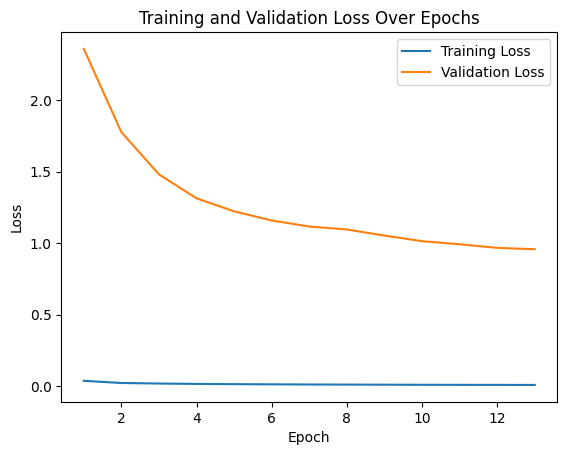

Epoch 13: 
train:		(loss: 0.0080) 
validation:	(loss: 0.9567)



100%|██████████| 522/522 [00:32<00:00, 16.21it/s, loss=0.007783627297222557] 


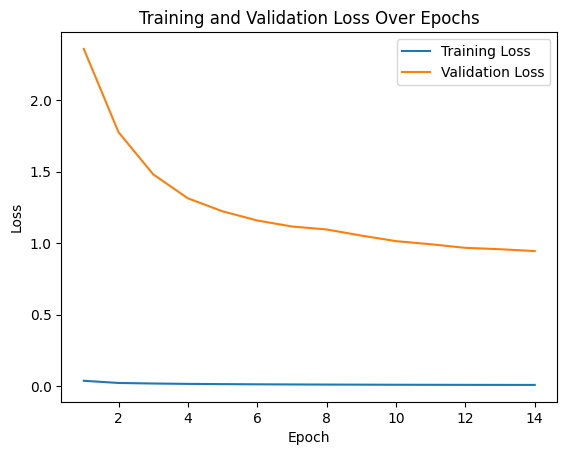

Epoch 14: 
train:		(loss: 0.0078) 
validation:	(loss: 0.9438)



100%|██████████| 522/522 [00:30<00:00, 17.38it/s, loss=0.00765959593249749]  


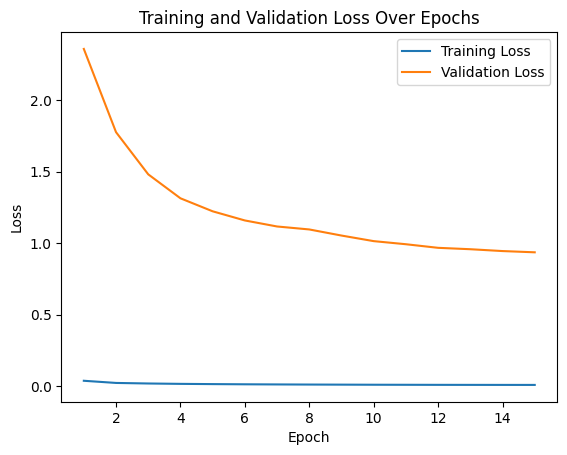

Epoch 15: 
train:		(loss: 0.0077) 
validation:	(loss: 0.9351)



100%|██████████| 522/522 [00:30<00:00, 17.33it/s, loss=0.007562383460737337] 


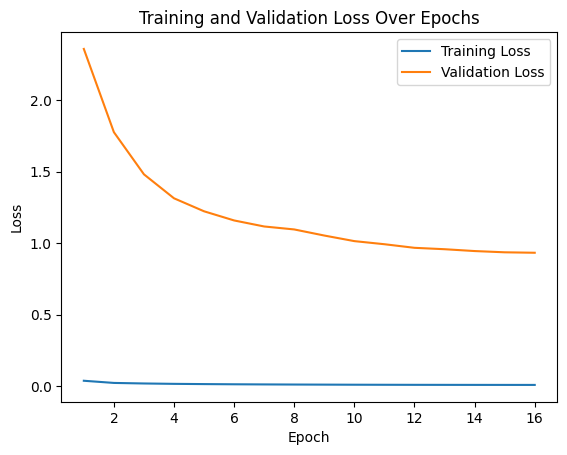

Epoch 16: 
train:		(loss: 0.0076) 
validation:	(loss: 0.9319)



100%|██████████| 522/522 [00:30<00:00, 17.36it/s, loss=0.007511410275224411] 


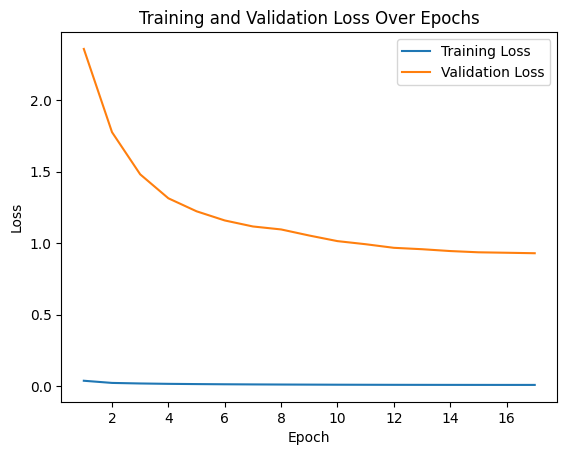

Epoch 17: 
train:		(loss: 0.0075) 
validation:	(loss: 0.9286)



100%|██████████| 522/522 [00:30<00:00, 17.16it/s, loss=0.007477401588932822] 


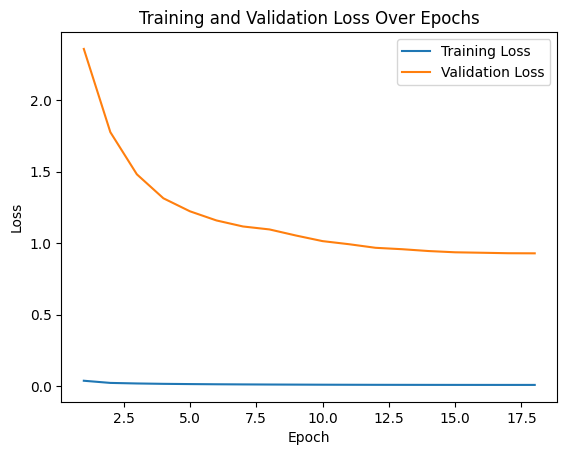

Epoch 18: 
train:		(loss: 0.0075) 
validation:	(loss: 0.9279)



100%|██████████| 522/522 [00:30<00:00, 17.26it/s, loss=0.007436589370892022] 


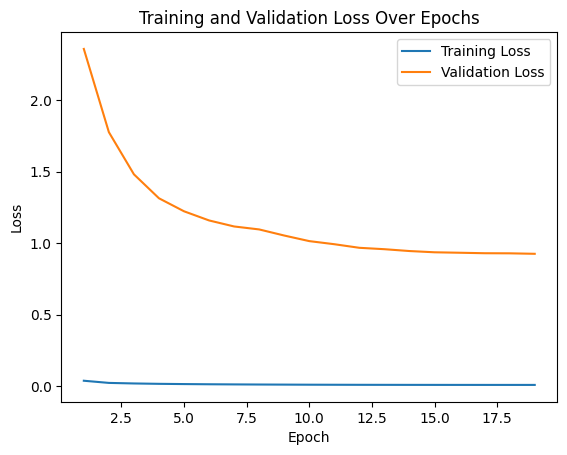

Epoch 19: 
train:		(loss: 0.0074) 
validation:	(loss: 0.9245)



100%|██████████| 522/522 [00:30<00:00, 17.23it/s, loss=0.007449081485156127] 


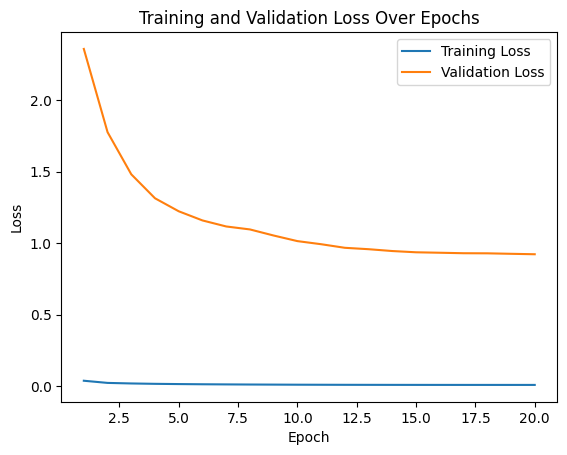

Epoch 20: 
train:		(loss: 0.0075) 
validation:	(loss: 0.9214)



In [19]:
train_model(model=model, epochs=config.epochs, criterion=loss_fn, train_dataloader=train_dataloader, validation_dataloader=val_dataloader)

In [20]:
checkpoint = torch.load('best.pt')

In [21]:
model.eval()
model.to(config.device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)

In [23]:
def get_top_k_movies(model, user_id, k=10):
    model.eval()

    watched_movies = val_data[val_data.user_id == user_id].item_id

    unwatched_movies = item_data[~item_data.index.isin(watched_movies)]

    unwatched_movie_ids = unwatched_movies.index.to_list()

    users_info_one_row = user_data.iloc[user_id]
    
    users_info = dup_rows(users_info_one_row.to_numpy()[np.newaxis, ...],
                          0, len(unwatched_movie_ids)-1)

    user_ids = [user_id] * len(unwatched_movie_ids)

    items_info = np.zeros((len(unwatched_movie_ids), n_item_features))
    for i, movie_id in enumerate(unwatched_movie_ids):
        items_info[i] = item_data.iloc[movie_id].to_numpy()

    user_ids = torch.tensor(user_ids).to(dtype=torch.long)
    item_ids = torch.tensor(unwatched_movie_ids).to(dtype=torch.long)
    users_info = torch.tensor(users_info).to(dtype=torch.float)
    items_info = torch.tensor(items_info).to(dtype=torch.float)

    with torch.no_grad():
        output = model(user_ids=user_ids, item_ids=item_ids,
                       users_info=users_info, items_info=items_info).squeeze()

    unwatched_movies_with_rating = list(
        zip(unwatched_movie_ids, output.numpy()))

    top_k = sorted(unwatched_movies_with_rating,
                   key=lambda x: x[1], reverse=True)[:k]

    return top_k

In [24]:
SOURCE_DATA_DIR = '../data/raw/ml-100k'

In [25]:
df_item = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.item'), sep='|', encoding = "ISO-8859-1", header=None)
genre_columns = ["unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documentary", "drama", "fantasy", "film_noir", "horror", "musical", "mystery", "romance", "sci_fi", "thriller", "war", "western"]
df_item.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "imdb_url"] + genre_columns
df_item = df_item.drop(columns=['video_release_date'])
df_item = df_item.set_index('movie_id')

In [26]:
df_user = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.user'), sep='|', header=None)
df_user.columns = ["user_id", "age", "gender", "occupation", "zip_code"]
df_user = df_user.set_index('user_id')

In [27]:
class ItemInfo:
    def __init__(self, movie_id, movie_title, release_date, genre_series):
        self.movie_id = movie_id
        self.movie_title = movie_title
        self.release_date = release_date
        self.genres = [genre for genre, value in genre_series.items() if value == 1]
    def __str__(self) -> str:
        return f'Movie (id {self.movie_id}):\ttitle: {self.movie_title},\tgenres: {self.genres}'

In [28]:
class UserInfo:
    def __init__(self, user_id, age, gender, occupation, zip_code):
        self.user_id = user_id
        self.age = age
        self.gender = gender
        self.occupation = occupation
        self.zip_code = zip_code
    def __repr__(self) -> str:
        return f'User (id {self.user_id}):\tage: {self.age},\tgender: {self.gender},\toccupation: {self.occupation}'

In [29]:
def get_item_info(item_id):
    original_id = original_item_ids.iloc[item_id]
    item_series = df_item.iloc[original_id]
    item_data = ItemInfo(movie_id=original_id, movie_title=item_series.movie_title, release_date=item_series.release_date, genre_series=item_series.loc[genre_columns])
    return item_data

In [30]:
def get_user_info(user_id):
    original_id = original_user_ids.iloc[user_id]
    user_series = df_user.iloc[original_id]
    user_data = UserInfo(user_id=original_id, age=user_series.age, gender=user_series.gender, occupation=user_series.occupation, zip_code=user_series.zip_code)
    return user_data

In [31]:
def get_user_recommendations(user_id, k=5):
    print(get_user_info(user_id=user_id))
    print(f"Top {k} recommendations:")
    item_ratings = get_top_k_movies(model=model, user_id=user_id, k=k)
    for i, (item_id, rating) in enumerate(item_ratings):
        print(f'{i+1}. Rating: {rating:0.3f}', end='. ')
        print(get_item_info(item_id=item_id))
        print()

In [32]:
def get_user_watched_movies(user_id, k=5):
    print(get_user_info(user_id=user_id))
    print(f"Top {k} recommendations:")
    watched_movies = val_data[val_data.user_id == user_id].item_id
    watched_movie_ids = watched_movies.to_list()

    watched_movies_with_rating = []

    for i, movie_id in enumerate(watched_movie_ids):
        rating = val_data[(val_data.item_id == movie_id) & (val_data.user_id == user_id)].rating.values[0]
        watched_movies_with_rating.append((movie_id, rating))

    item_ratings = sorted(watched_movies_with_rating,key=lambda x: x[1], reverse=True)[:k]

    for i, (item_id, rating) in enumerate(item_ratings):
        print(f'{i+1}. Rating: {rating:0.3f}', end='. ')
        print(get_item_info(item_id=item_id))
        print()
    


In [33]:
get_user_watched_movies(user_id=23, k=10)

User (id 28):	age: 41,	gender: M,	occupation: programmer
Top 10 recommendations:
1. Rating: 5.000. Movie (id 660):	title: High Noon (1952),	genres: ['western']

2. Rating: 5.000. Movie (id 267):	title: Chasing Amy (1997),	genres: ['drama', 'romance']

3. Rating: 4.000. Movie (id 1017):	title: Tie Me Up! Tie Me Down! (1990),	genres: ['drama']

4. Rating: 4.000. Movie (id 181):	title: GoodFellas (1990),	genres: ['crime', 'drama']



In [34]:
get_user_recommendations(user_id=23, k=10)

User (id 28):	age: 41,	gender: M,	occupation: programmer
Top 10 recommendations:
1. Rating: 4.318. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

2. Rating: 4.312. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

3. Rating: 4.267. Movie (id 11):	title: Usual Suspects, The (1995),	genres: ['crime', 'thriller']

4. Rating: 4.262. Movie (id 168):	title: Wrong Trousers, The (1993),	genres: ['animation', 'comedy']

5. Rating: 4.227. Movie (id 113):	title: Wallace & Gromit: The Best of Aardman Animation (1996),	genres: ['animation']

6. Rating: 4.210. Movie (id 49):	title: Star Wars (1977),	genres: ['action', 'adventure', 'romance', 'sci_fi', 'war']

7. Rating: 4.208. Movie (id 407):	title: Close Shave, A (1995),	genres: ['animation', 'comedy', 'thriller']

8. Rating: 4.204. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

9. Rating: 4.188. Movie (id 271):	title: Good Will Hunting (1997),	genres: ['drama']

10. Ratin

In [35]:
get_user_watched_movies(user_id=69, k=10)

User (id 91):	age: 32,	gender: M,	occupation: entertainment
Top 10 recommendations:
1. Rating: 5.000. Movie (id 432):	title: Heathers (1989),	genres: ['comedy']

2. Rating: 5.000. Movie (id 55):	title: Pulp Fiction (1994),	genres: ['crime', 'drama']

3. Rating: 5.000. Movie (id 11):	title: Usual Suspects, The (1995),	genres: ['crime', 'thriller']

4. Rating: 5.000. Movie (id 197):	title: Nikita (La Femme Nikita) (1990),	genres: ['thriller']

5. Rating: 4.000. Movie (id 1011):	title: Private Parts (1997),	genres: ['comedy', 'drama']

6. Rating: 4.000. Movie (id 50):	title: Legends of the Fall (1994),	genres: ['drama', 'romance', 'war', 'western']

7. Rating: 4.000. Movie (id 822):	title: Mulholland Falls (1996),	genres: ['crime', 'film_noir', 'thriller']

8. Rating: 4.000. Movie (id 4):	title: Copycat (1995),	genres: ['crime', 'drama', 'thriller']

9. Rating: 4.000. Movie (id 47):	title: Hoop Dreams (1994),	genres: ['documentary']

10. Rating: 4.000. Movie (id 218):	title: Nightmare on 

In [36]:
get_user_recommendations(user_id=69, k=10)

User (id 91):	age: 32,	gender: M,	occupation: entertainment
Top 10 recommendations:
1. Rating: 4.376. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

2. Rating: 4.367. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

3. Rating: 4.267. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

4. Rating: 4.247. Movie (id 271):	title: Good Will Hunting (1997),	genres: ['drama']

5. Rating: 4.237. Movie (id 479):	title: North by Northwest (1959),	genres: ['comedy', 'thriller']

6. Rating: 4.216. Movie (id 407):	title: Close Shave, A (1995),	genres: ['animation', 'comedy', 'thriller']

7. Rating: 4.214. Movie (id 177):	title: 12 Angry Men (1957),	genres: ['drama']

8. Rating: 4.208. Movie (id 478):	title: Vertigo (1958),	genres: ['mystery', 'thriller']

9. Rating: 4.207. Movie (id 126):	title: Godfather, The (1972),	genres: ['action', 'crime', 'drama']

10. Rating: 4.200. Movie (id 497):	title: African Queen, The (1951),	genr

In [43]:
get_user_watched_movies(user_id=96, k=10)

User (id 127):	age: 24,	gender: F,	occupation: marketing
Top 10 recommendations:
1. Rating: 5.000. Movie (id 185):	title: Blues Brothers, The (1980),	genres: ['action', 'comedy', 'musical']

2. Rating: 5.000. Movie (id 602):	title: Rear Window (1954),	genres: ['mystery', 'thriller']

3. Rating: 5.000. Movie (id 489):	title: To Catch a Thief (1955),	genres: ['comedy', 'romance', 'thriller']

4. Rating: 5.000. Movie (id 85):	title: Remains of the Day, The (1993),	genres: ['drama']

5. Rating: 5.000. Movie (id 222):	title: Sling Blade (1996),	genres: ['drama', 'thriller']

6. Rating: 5.000. Movie (id 116):	title: Rock, The (1996),	genres: ['action', 'adventure', 'thriller']

7. Rating: 5.000. Movie (id 179):	title: Apocalypse Now (1979),	genres: ['drama', 'war']

8. Rating: 4.000. Movie (id 507):	title: People vs. Larry Flynt, The (1996),	genres: ['drama']

9. Rating: 4.000. Movie (id 196):	title: Graduate, The (1967),	genres: ['drama', 'romance']

10. Rating: 4.000. Movie (id 70):	title:

In [38]:
get_user_recommendations(user_id=96, k=10)

User (id 127):	age: 24,	gender: F,	occupation: marketing
Top 10 recommendations:
1. Rating: 4.352. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

2. Rating: 4.351. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

3. Rating: 4.324. Movie (id 168):	title: Wrong Trousers, The (1993),	genres: ['animation', 'comedy']

4. Rating: 4.307. Movie (id 11):	title: Usual Suspects, The (1995),	genres: ['crime', 'thriller']

5. Rating: 4.278. Movie (id 113):	title: Wallace & Gromit: The Best of Aardman Animation (1996),	genres: ['animation']

6. Rating: 4.274. Movie (id 49):	title: Star Wars (1977),	genres: ['action', 'adventure', 'romance', 'sci_fi', 'war']

7. Rating: 4.249. Movie (id 512):	title: Third Man, The (1949),	genres: ['mystery', 'thriller']

8. Rating: 4.246. Movie (id 177):	title: 12 Angry Men (1957),	genres: ['drama']

9. Rating: 4.238. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

10. Rating: 4.220. Movie (

In [39]:
get_user_watched_movies(user_id=700, k=10)

User (id 917):	age: 40,	gender: M,	occupation: scientist
Top 10 recommendations:
1. Rating: 5.000. Movie (id 427):	title: Harold and Maude (1971),	genres: ['comedy']

2. Rating: 4.000. Movie (id 581):	title: Piano, The (1993),	genres: ['drama', 'romance']

3. Rating: 4.000. Movie (id 165):	title: Manon of the Spring (Manon des sources) (1986),	genres: ['drama']

4. Rating: 4.000. Movie (id 920):	title: Farewell My Concubine (1993),	genres: ['drama', 'romance']

5. Rating: 3.000. Movie (id 0):	title: Toy Story (1995),	genres: ['animation', 'children', 'comedy']

6. Rating: 3.000. Movie (id 484):	title: My Fair Lady (1964),	genres: ['musical', 'romance']

7. Rating: 3.000. Movie (id 69):	title: Four Weddings and a Funeral (1994),	genres: ['comedy', 'romance']

8. Rating: 2.000. Movie (id 288):	title: Evita (1996),	genres: ['drama', 'musical']

9. Rating: 2.000. Movie (id 150):	title: Willy Wonka and the Chocolate Factory (1971),	genres: ['adventure', 'children', 'comedy']

10. Rating: 2.

In [44]:
get_user_recommendations(user_id=700, k=10)

User (id 917):	age: 40,	gender: M,	occupation: scientist
Top 10 recommendations:
1. Rating: 4.227. Movie (id 168):	title: Wrong Trousers, The (1993),	genres: ['animation', 'comedy']

2. Rating: 4.180. Movie (id 113):	title: Wallace & Gromit: The Best of Aardman Animation (1996),	genres: ['animation']

3. Rating: 4.167. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

4. Rating: 4.147. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

5. Rating: 4.110. Movie (id 177):	title: 12 Angry Men (1957),	genres: ['drama']

6. Rating: 4.108. Movie (id 512):	title: Third Man, The (1949),	genres: ['mystery', 'thriller']

7. Rating: 4.083. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

8. Rating: 4.080. Movie (id 49):	title: Star Wars (1977),	genres: ['action', 'adventure', 'romance', 'sci_fi', 'war']

9. Rating: 4.075. Movie (id 497):	title: African Queen, The (1951),	genres: ['action', 'adventure', 'romance', 'war']

10. Ra